#### Go to https://pytorch.org/ and follow the instructions to install PyTorch.

## Imports

In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


from IPython.display import Image, display, clear_output
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
import pandas as pd
from PIL import Image, ImageOps
# %matplotlib notebook

# get rid of uninteresting warning
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## Import dataset

In [2]:
# path = Path().cwd()

# data_file = "zipdata.mat"
# data = scipy.io.loadmat(data_file)

path = 'data/UTKFace/'
df = pd.read_csv("data/info.csv")[:9000]
data = [ImageOps.grayscale(Image.open(path+img)) for img in df.filename]
X = np.stack(data).reshape(len(data), -1)

# labels
labels = df["race"].values
gender_dict = {0:"male", 1:"female"}
race_dict = {0:"white", 1:"black", 2:"asian", 3:"indian", 4:"others"}

# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = .33)

# X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y'], test_size=0.33, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float)
# classes = [0,1,2,3,4,5,6,7,8,9]
classes = np.unique(df["race"])

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([6030, 40000]),
 torch.Size([6030, 1]),
 torch.Size([2970, 40000]),
 torch.Size([2970, 1]))

### setup loaders

In [3]:
BATCH_SIZE = 64
EPOCH = 200

train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

test_dataset = Data.TensorDataset(X_test, y_test)
test_loader = Data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

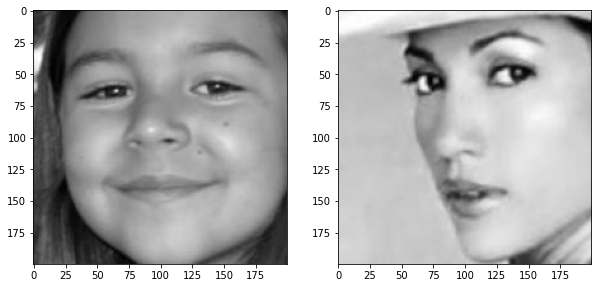

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    img = X_test[i].reshape(200, 200)
    ax[i].imshow(img, cmap='gray')

## Artificial Neural Network

In [4]:
class AutoEncoderNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden_features, latent_features):
        super(AutoEncoderNet, self).__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_feature, n_hidden_features),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden_features, latent_features)
          ).to(self.device)
        
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_features, n_hidden_features),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden_features, n_feature)
        ).to(self.device)

    def forward(self, x):
        latent_space = self.encoder(x)

        x_reconstruction = self.decoder(latent_space)
        
        
        return latent_space, x_reconstruction
    
number_of_features = 200*200 #256
n_hidden_features = 200 #Try changing this
latent_features = 100 #Try changing this
learning_rate = 0.01 #Try changing this
# L2 Regularization is added to the optimizer as weight decay, use a number between 0 and 1
# If more regularization is desired then you can add dropout to the network 
weight_decay = 0.0 #Try changing this
    
aenet = AutoEncoderNet(n_feature=number_of_features, n_hidden_features=n_hidden_features, latent_features=latent_features)     # define the network
print(aenet)  # net architecture
optimizer = torch.optim.Adam(aenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_func = torch.nn.MSELoss()  # MSE loss function

AutoEncoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=40000, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=40000, bias=True)
  )
)


## Early stopping

In [5]:
# from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.bestModel = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics, curmodel):
        if self.best is None:
            self.best = metrics
            self.bestModel = curmodel
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
            self.bestModel = curmodel
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)
                

                
# play around with patience
# The early stopping module takes in the following parameters
# mode='min' / 'max' - whether smaller or lager is better
# min_delta=0 - a delta that can be used to be more lenient when evaulating "bad" epochs
# patience=10 - how many "bad" epochs that are allowed(epoches with worse score than the current best)
# percentage=False / True - whether the criterion is in percentage or not
earlyStopping = EarlyStopping(patience=10)

### 3)  Try compressing the zip data with an autoencoder. The weights in the encoder represents the pattern used in each latent variable: 

Epoch [1/200], Train Loss: 4095464.1196, Test Loss: 19707.2697
Epoch [2/200], Train Loss: 19664.3592, Test Loss: 19669.2937
Epoch [3/200], Train Loss: 19621.1287, Test Loss: 19620.9825
Epoch [4/200], Train Loss: 19568.8557, Test Loss: 19564.7221
Epoch [5/200], Train Loss: 19509.1027, Test Loss: 19501.5405
Epoch [6/200], Train Loss: 19442.9990, Test Loss: 19432.3746
Epoch [7/200], Train Loss: 19371.1659, Test Loss: 19357.7013
Epoch [8/200], Train Loss: 19294.1232, Test Loss: 19278.1956
Epoch [9/200], Train Loss: 19212.2841, Test Loss: 19193.8511
Epoch [10/200], Train Loss: 19125.9136, Test Loss: 19105.2585
Epoch [11/200], Train Loss: 19035.3029, Test Loss: 19012.5116
Epoch [12/200], Train Loss: 18940.7432, Test Loss: 18915.9271
Epoch [13/200], Train Loss: 18842.3925, Test Loss: 18815.5826
Epoch [14/200], Train Loss: 18740.4041, Test Loss: 18711.6362
Epoch [15/200], Train Loss: 18634.9108, Test Loss: 18604.4632
Epoch [16/200], Train Loss: 18526.2162, Test Loss: 18494.0461
Epoch [17/200],

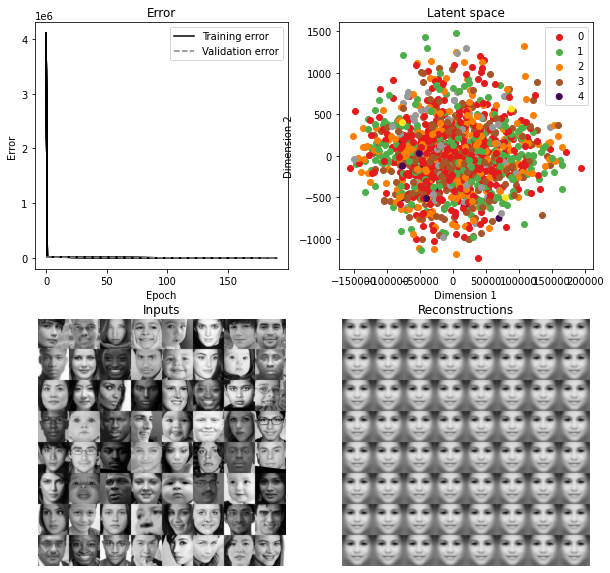

In [6]:
f, axarr = plt.subplots(2, 2, figsize=(10, 10))
h,w = 200, 200

# train the neural network

average_test_loss=[]
average_train_loss=[]
for epoch in range(EPOCH):  # loop over the dataset multiple times

    train_loss_graph = 0
    aenet.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        xtrain, ytrain = data
        xtrain = xtrain.to(aenet.device)
        ytrain = ytrain.to(aenet.device)

        # forward + backward + optimize
        latent_space, x_reconstruction = aenet(xtrain)

        loss = loss_func(x_reconstruction, xtrain)
        train_loss_graph += loss.item() * xtrain.shape[0] #Multiply with the current batchsize to get pr. sample loss
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    
    # testing
    test_loss_graph  = 0
    with torch.no_grad():
        aenet.eval()
        for data in test_loader:
            xtest, ytest = data
            xtest = xtest.to(aenet.device)
            ytest = ytest.to(aenet.device)
            latent_space, x_reconstruction = aenet(xtest)
            loss = loss_func(x_reconstruction, xtest)
            test_loss_graph += loss.item() * xtest.shape[0] #Multiply with the current batchsize to get pr. sample loss


    average_train_loss.append(train_loss_graph/len(train_dataset))
    average_test_loss.append(test_loss_graph/len(test_dataset))

    print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(
        epoch + 1, EPOCH, train_loss_graph/len(train_dataset), test_loss_graph/len(test_dataset)))

    # plotting code from dtu deep learning course
    if epoch % 10 == 0:
        ax = axarr[0, 0]
        ax.set_title("Error")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Error')


        ax.plot(np.arange(epoch+1), average_train_loss, color="black")
        ax.plot(np.arange(epoch+1), average_test_loss, color="gray", linestyle="--")
        ax.legend(['Training error', 'Validation error'])

        # Latent space
        ax = axarr[0, 1]

        ax.set_title('Latent space')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')

        # If you want to use a dimensionality reduction method you can use
        # for example PCA by projecting on two principal dimensions
        # print(latent_space.shape)
        # ytest = ytest.cpu()
        # xtest = xtest.cpu()
        for data in test_loader:
            xtest, ytest = data
            xtest = xtest.to(aenet.device)
            latent_space, x_reconstruction = aenet(xtest)
            xtest = xtest.cpu()
            ytest = ytest.cpu()
            break
        
        

        x_reconstruction = x_reconstruction.detach().cpu()
        latent_space = latent_space.squeeze().detach().cpu()
        latent_space = PCA(n_components=2).fit_transform(latent_space)

        colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
        for c in classes:
            ax.scatter(*latent_space[ytest.numpy().squeeze() == c].T, c=next(colors), marker='o')

        ax.legend(classes)

        # Inputs
        ax = axarr[1, 0]
        ax.set_title('Inputs')
        ax.axis('off')

        rows = 8
        # columns = BATCH_SIZE // rows
        columns = 8

        canvas = np.zeros((h*rows, columns*w))
        for i in range(rows):
            for j in range(columns):
                idx = i % columns + rows * j
                canvas[i*h:(i+1)*h, j*w:(j+1)*w] = xtest[idx].reshape((h,w))
        ax.imshow(canvas, cmap='gray')


        # Reconstructions
        ax = axarr[1, 1]
        ax.set_title('Reconstructions')
        ax.axis('off')

        canvas = np.zeros((h*rows, columns*w))
        for i in range(rows):
            for j in range(columns):
                idx = i % columns + rows * j
                canvas[i*h:(i+1)*h, j*w:(j+1)*w] = x_reconstruction[idx].reshape((h,w))


        ax.imshow(canvas, cmap='gray')
        f.canvas.draw()       # draw the canvas, cache the renderer
        # Early stopping
        if earlyStopping.step(torch.tensor(test_loss_graph/len(test_dataset)),aenet):
            print ("Stopping early")
            aenet = earlyStopping.bestModel
            break

print('Finished Training')

In [82]:
x_reconstruction.shape

torch.Size([26, 40000])

In [87]:
im1 = x_reconstruction.cpu()[0].reshape((h,w))
im2 = x_reconstruction.cpu()[20].reshape((h,w))
im3 = im1-im2
# plt.imshow(im3, cmap='gray')
im3.sum()

tensor(0.)